In [48]:
import re
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# NVDA Analysis of Similarity Scores
Using the scraped data, we want to do a preliminary analysis of the NVDA 10K and 10Q similarity scores (basically meaning we just want to graph them). We choose NVDA in particular because my dad is interested in the stock. Afterwards we'll try to implement a function that automates the graph-making process and stores the result as a pdf file. 

In [2]:
# helpful tool to convert between ticker to CIV
def TickertoCIK(tickers):
    url = 'http://www.sec.gov/cgi-bin/browse-edgar?CIK={}&Find=Search&owner=exclude&action=getcompany'
    cik_re = re.compile(r'.*CIK=(\d{10}).*')

    cik_dict = {}
    for ticker in tqdm(tickers): # Use tqdm lib for progress bar
        results = cik_re.findall(requests.get(url.format(ticker)).text)
        if len(results):
            cik_dict[str(ticker).lower()] = str(results[0])
    
    return cik_dict

In [3]:
# we are analyzing NVDA
cik_dict = TickertoCIK(["nvda"])
cik = cik_dict['nvda']

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


In [4]:
# import scraped similarity data
data = pd.read_csv(cik + '_sim_scores_full.csv')

In [5]:
# data

In [6]:
# we need to turn this dataframe into a numpy array so that we can plot stuff. Let's clean up the data while 
# we're at it and create two numpy arrays for 10Q and 10K similarity data.

def get_10K_data(data):
    '''
    Helper function: 
    Takes in the pandas dataframe containing all the sim scores for 10Ks and 10Qs and generates a 
    cleaned up dataframe with just 10Ks of the form: 
    
    10Q Dates | cosine_score | jaccard_score
    
    '''
    df = data.copy()
    df = df[pd.notnull(df['10Kdates'])]
    df.drop(['10Qdates'], 1, inplace=True)
    df.drop(['cik'], 1, inplace=True)
    
    return df

def get_10Q_data(data):
    '''
    Helper function: 
    Takes in the pandas dataframe containing all the sim scores for 10Ks and 10Qs and generates a 
    cleaned up dataframe with just 10Qs of the form: 
    
    10Q Dates | cosine_score | jaccard_score
    
    '''
    df = data.copy()
    df = df[pd.notnull(df['10Qdates'])]
    df.drop(['10Kdates'], 1, inplace=True)
    df.drop(['cik'], 1, inplace=True)
    
    return df

In [8]:
K_data = get_10K_data(data)
Q_data = get_10Q_data(data)

In [9]:
# Q_data

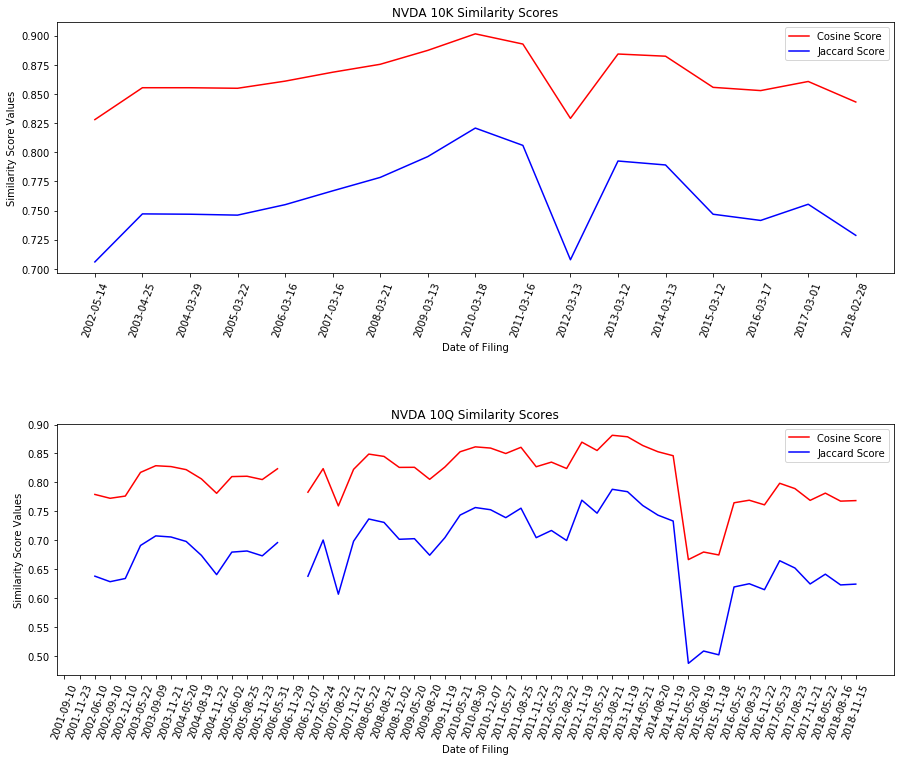

In [52]:
# plot 10K similarities
K_array = K_data.values
Q_array = Q_data.values

fig = plt.figure(figsize = (15, 12))
# fig.tight_layout()
# fig.set_figwidth(fig.get_figwidth() * 3)
# fig.set_figheight(fig.get_figheight() * 5)

axes = fig.add_subplot(2, 1, 1)
axes.plot(K_array[:, 0], K_array[:, 1], '-r', label = "Cosine Score")
axes.plot(K_array[:, 0], K_array[:, 2], '-b', label = "Jaccard Score")
axes.legend()
axes.set_title('NVDA 10K Similarity Scores')
axes.set_xlabel('Date of Filing')
axes.set_ylabel("Similarity Score Values")
plt.xticks(rotation=70)

axes = fig.add_subplot(2, 1, 2)
axes.plot(Q_array[:, 0], Q_array[:, 1], '-r', label = "Cosine Score")
axes.plot(Q_array[:, 0], Q_array[:, 2], '-b', label = "Jaccard Score")
axes.legend()
axes.set_title('NVDA 10Q Similarity Scores')
axes.set_xlabel('Date of Filing')
axes.set_ylabel("Similarity Score Values")
plt.xticks(rotation=70)

plt.subplots_adjust(hspace = 0.6)
plt.show()

In [49]:
# practice saving graphs
K_array = K_data.values

with PdfPages('foo.pdf') as pdf:
    fig = plt.figure(figsize = (15, 12))

    axes = fig.add_subplot(2, 1, 1)
    axes.plot(K_array[:, 0], K_array[:, 1], '-r', label = "Cosine Score")
    axes.plot(K_array[:, 0], K_array[:, 2], '-b', label = "Jaccard Score")
    axes.legend()
    axes.set_title('NVDA 10K Similarity Scores')
    axes.set_xlabel('Date of Filing')
    axes.set_ylabel("Similarity Score Values")
    plt.xticks(rotation=70)

    axes = fig.add_subplot(2, 1, 2)
    axes.plot(Q_array[:, 0], Q_array[:, 1], '-r', label = "Cosine Score")
    axes.plot(Q_array[:, 0], Q_array[:, 2], '-b', label = "Jaccard Score")
    axes.legend()
    axes.set_title('NVDA 10Q Similarity Scores')
    axes.set_xlabel('Date of Filing')
    axes.set_ylabel("Similarity Score Values")
    plt.xticks(rotation=70)

    plt.subplots_adjust(hspace = 0.6)
    pdf.savefig()

In [55]:
# time to automate these and test before we move to making the python script. 

def plot(ticker, data):
    '''
    Inputs: 
        1. ticker: the name of the ticker which the data (#2) refers to. 
        2. data: The pandas dataframe for the ticker in #1 containing all the sim scores for 10Ks and 10Qs
    
    This function cleans the similarity score data up into two dataframes (Q_data, K_data) of dates and sim scores 
    for 10Ks, 10Qs, plots a single figure containing two subplots plotting similarity scores for the 10Ks and 10Qs, 
    and saves the file as a pdf in the current directory. 
    
    '''
    K_data = get_10K_data(data)
    Q_data = get_10Q_data(data)
    
    K_array = K_data.values
    Q_array = Q_data.values

    with PdfPages(ticker + '.pdf') as pdf:
        fig = plt.figure(figsize = (15, 12))

        axes = fig.add_subplot(2, 1, 1)
        axes.plot(K_array[:, 0], K_array[:, 1], '-r', label = "Cosine Score")
        axes.plot(K_array[:, 0], K_array[:, 2], '-b', label = "Jaccard Score")
        axes.legend()
        axes.set_title(ticker.upper() + ' 10K Similarity Scores')
        axes.set_xlabel('Date of Filing')
        axes.set_ylabel("Similarity Score Values")
        plt.xticks(rotation=70)

        axes = fig.add_subplot(2, 1, 2)
        axes.plot(Q_array[:, 0], Q_array[:, 1], '-r', label = "Cosine Score")
        axes.plot(Q_array[:, 0], Q_array[:, 2], '-b', label = "Jaccard Score")
        axes.legend()
        axes.set_title(ticker.upper() + ' 10Q Similarity Scores')
        axes.set_xlabel('Date of Filing')
        axes.set_ylabel("Similarity Score Values")
        plt.xticks(rotation=70)

        plt.subplots_adjust(hspace = 0.6)
        pdf.savefig()

In [56]:
plot('nvda', data)